<a href="https://colab.research.google.com/github/Abhi951197/npk_arpit_model/blob/main/pleural_effusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PLEURAL-EFFUSION

In [1]:
!pip install ct-counterfactuals --upgrade
!pip install git+https://github.com/ieee8023/captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3

In [2]:
!mkdir volumes
!wget -q https://github.com/ieee8023/ct-counterfactuals/raw/main/volumes/TCIA-LCTSC-_RCCTPET_THORAX_CONTRAST_dag0_20080918110916_4268307088.nii.gz -O volumes/TCIA-LCTSC-_RCCTPET_THORAX_CONTRAST_dag0_20080918110916_4268307088.nii.gz

In [3]:
%pip install nibabel matplotlib pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 32.2 MB/s eta 0:00:00


In [5]:
import numpy as np
print(np.__version__)


2.0.2


In [6]:
!pip uninstall -y numpy
!pip install numpy==1.26.4

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


RESTART

<ipython-input-1-4334fc4feac9>:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


(512, 512, 134)
(512, 512, 134)
(512, 512)


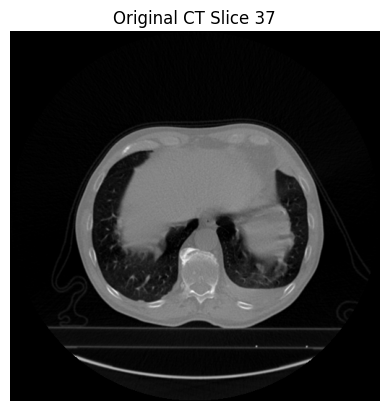

In [1]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.autonotebook import tqdm
import skimage
import glob
import captum
import latentshift
import ct_counterfactuals as ct_cf
import latentshift
import captum
import nibabel as nib


# Set device
device = torch.device("cuda")  # Use "cuda" if GPU is available

# ---------------------------------------
# Step 1: Load CT Scan and Display Slice
# ---------------------------------------
nii = nib.load("/content/volumes/TCIA-LCTSC-_RCCTPET_THORAX_CONTRAST_dag0_20080918110916_4268307088.nii.gz")
print(nii.shape)
data = nii.get_fdata()
print(data.shape)
slice_index = 37
axial_slice = data[:, :, slice_index]
print(axial_slice.shape)

# Display original slice
plt.imshow(axial_slice.T, cmap='gray', origin='lower')
plt.title(f"Original CT Slice {slice_index}")
plt.axis('off')
plt.show()

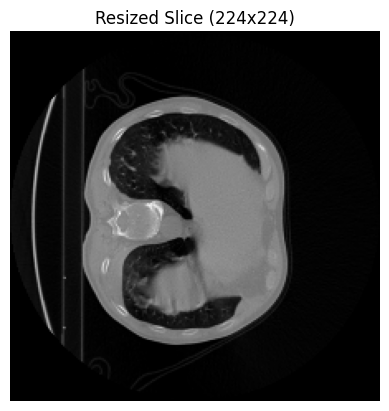

In [2]:
import torch.nn.functional as F
x = torch.tensor(axial_slice).float()
x = (x - x.min()) / (x.max() - x.min())  # Normalize to [0, 1]
x_resized = F.interpolate(x.unsqueeze(0).unsqueeze(0), size=(224, 224), mode='bilinear')[0, 0]

# Display resized image
plt.imshow(x_resized.cpu().numpy(), cmap='gray')
plt.title("Resized Slice (224x224)")
plt.axis('off')
plt.show()

HERE YOU CAN CHANGE THE CACHE IF NOT ON COLAB

In [4]:
import os
print(os.getenv("XDG_CACHE_HOME"))  # usually None unless explicitly set
print(os.path.expanduser("~"))      # this will print /home/zeus on your setup


None
/root


In [3]:
data = ct_cf.datasets.NIFTI_Dataset('volumes/', resolution=224)import torch
from torch.serialization import add_safe_globals
import pytorch_lightning.callbacks.model_checkpoint
import ct_counterfactuals as ct_cf

# Allow this specific class to be unpickled
add_safe_globals([pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint])



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load VQ-GAN with explicit cache directory
ae = ct_cf.ae.VQGAN(
    weights='2023-12-25T10-26-40_ct2_vqgan256_sddd',
    download=True,
    cache_dir="/root/"
).to(device)

If this fails you can run `wget https://github.com/ieee8023/ct-counterfactuals/releases/download/init/2023-12-25T10-26-40_ct2_vqgan256_sddd.ckpt -O /root/2023-12-25T10-26-40_ct2_vqgan256_sddd.ckpt`
[██████████████████████████████████████████████████]
If this fails you can run `wget https://github.com/ieee8023/ct-counterfactuals/releases/download/init/2023-12-25T10-26-40_ct2_vqgan256_sddd.yaml -O /root/2023-12-25T10-26-40_ct2_vqgan256_sddd.yaml`
[██████████████████████████████████████████████████]
Working with z of shape (1, 256, 4, 4) = 4096 dimensions.


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 180MB/s]


8.19kB [00:00, 563kB/s]                    


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [5]:
data = ct_cf.datasets.NIFTI_Dataset('volumes/', resolution=224)

In [6]:
len(data)


1

In [7]:
img = data[0]['image'][None,...]
img.shape

torch.Size([1, 1, 224, 224, 134])

In [8]:
model= ct_cf.classifiers.phecode.PheCodeClassifier(download=True).to(device)


If this fails you can run `wget https://github.com/ieee8023/ct-counterfactuals/releases/download/init/i3_resnet_best_clip_04-02-2024_23-21-36_epoch_99.pt -O /root/.cache/latentshift/i3_resnet_best_clip_04-02-2024_23-21-36_epoch_99.pt`
[██████████████████████████████████████████████████]


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for i in range(1):
    sample = data[i]
    img = sample['image'][None, ...]
    with torch.no_grad():
        o = model(img.to(device)).cpu()
    print(i, os.path.basename(sample['image_path']))

    for ind, target in [(i, target) for i, target in enumerate(model.targets) if 'effusion' in target.lower()]:
        print("   " + str(float(o[:, ind])) + "  " + model.targets[ind])


0 TCIA-LCTSC-_RCCTPET_THORAX_CONTRAST_dag0_20080918110916_4268307088.nii.gz
   0.049167804419994354  Pleurisy; pleural effusion
   0.01295003667473793  Joint effusions


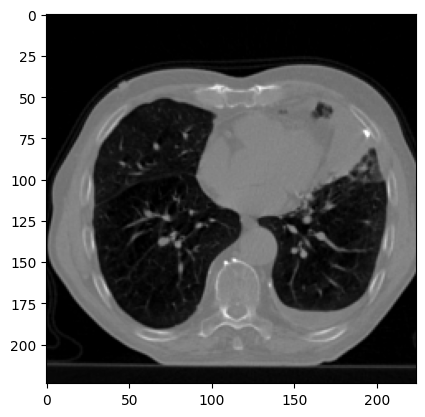

In [10]:
plt.imshow(img[0,0,:,:,58], cmap='gray');

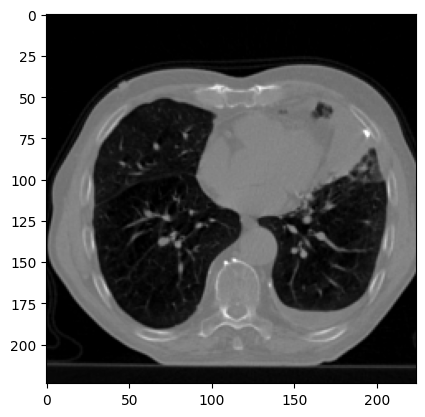

In [11]:
x = img[:,:,:,:,58]
plt.imshow(x[0][0].cpu().detach().numpy(), cmap='gray');

In [12]:
img.min(), img.max()

(metatensor(0.), metatensor(1.))

In [13]:
z = ae.encode(x.to(device))


In [14]:
img2 = ae.decode(z)

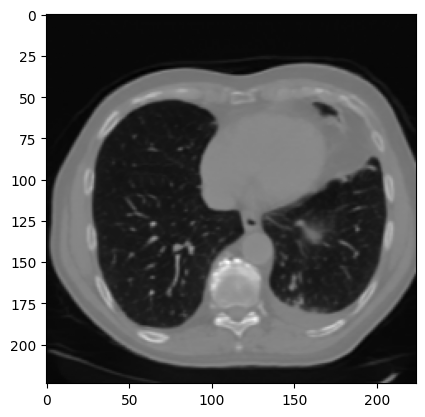

In [15]:
plt.imshow(img2[0][0].cpu().detach().numpy(), cmap='gray');

In [16]:
del z
del img2

In [17]:
attr = latentshift.cf.LatentShift(
    latentshift.alignment.ModelWrapper(
        model,
        target='Pleurisy; pleural effusion',
        adjustment=lambda x: x+0.6,
        rename_model='', sigmoid=False),
    ct_cf.ae.SliceAEFull(ae, 53,58),
)
output = attr.attribute(img.to(device), target=0,
                        return_dicts = True,
                        apply_sigmoid = True,
                        search_max_steps = 20000,
                       )[0]

Shift: 0, Pred: 0.6485550999641418, pixel_diff: 0.0, sum*diff_pct: 130881.3984375
Shift: -10.0, Pred: 0.6485517621040344, pixel_diff: 0.6854995489120483, sum*diff_pct: 130881.3984375
Shift: -21.0, Pred: 0.6485481858253479, pixel_diff: 1.4380207061767578, sum*diff_pct: 130881.3984375
Shift: -34.0, Pred: 0.6485439538955688, pixel_diff: 2.326374053955078, sum*diff_pct: 130881.3984375
Shift: -48.0, Pred: 0.6485393643379211, pixel_diff: 3.2853879928588867, sum*diff_pct: 130881.3984375
Shift: -63.0, Pred: 0.6485346555709839, pixel_diff: 4.3106913566589355, sum*diff_pct: 130881.3984375
Shift: -80.0, Pred: 0.6485292911529541, pixel_diff: 5.473531723022461, sum*diff_pct: 130881.3984375
Shift: -98.0, Pred: 0.6485236287117004, pixel_diff: 6.705260276794434, sum*diff_pct: 130881.3984375
Shift: -118.0, Pred: 0.648517370223999, pixel_diff: 8.073328018188477, sum*diff_pct: 130881.3984375
Shift: -140.0, Pred: 0.6485106348991394, pixel_diff: 9.577823638916016, sum*diff_pct: 130881.3984375
Shift: -164.0

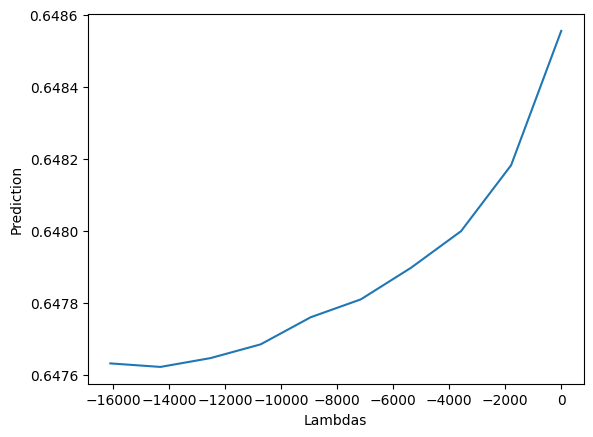

In [18]:
plt.plot(output['lambdas'],output['preds']);
plt.xlabel('Lambdas');
plt.ylabel('Prediction');

In [19]:
single_diffs = np.abs(output['heatmap']).sum(0).sum(0).sum(0)

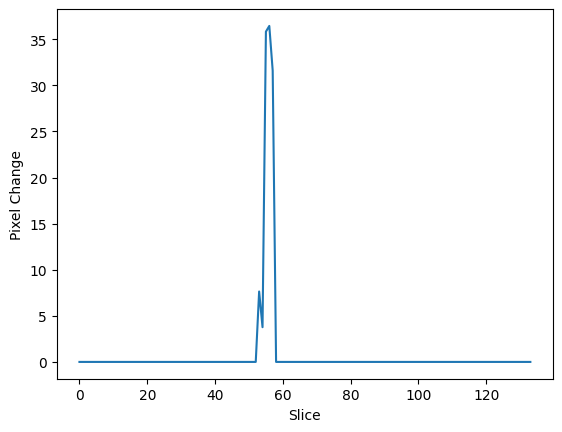

In [20]:
plt.plot(single_diffs);
plt.xlabel('Slice');
plt.ylabel('Pixel Change');

In [21]:
output['heatmap'].shape

(1, 224, 224, 134)

In [22]:
idx = output['heatmap'].sum(1).sum(1).argmax()
idx

56

In [23]:
idx =56

In [24]:
images = [output['generated_images'][i,...,idx] for i in range(len(output['generated_images']))]


In [25]:
generated_images = output.get('generated_images', None)

if generated_images is None:
    print("❌ No generated images found in output.")
else:
    print(f"✅ Number of generated images: {len(generated_images)}")


✅ Number of generated images: 10


In [27]:
images = [ct_cf.datasets.window_level(img, -1000, 100) for img in images]

0.01171875 0.548828125
0.01171875 0.548828125
0.01171875 0.548828125
0.01171875 0.548828125
0.01171875 0.548828125
0.01171875 0.548828125
0.01171875 0.548828125
0.01171875 0.548828125
0.01171875 0.548828125
0.01171875 0.548828125


In [28]:
images[0].shape

(1, 224, 224)

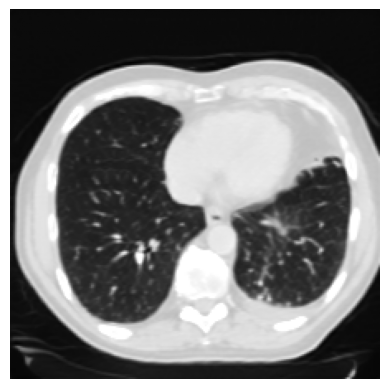

In [29]:
plt.imshow(images[0][0], cmap='gray');
plt.axis('off');

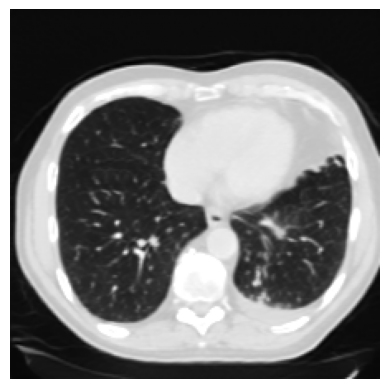

In [30]:
plt.imshow(images[-1][0], cmap='gray');
plt.axis('off');

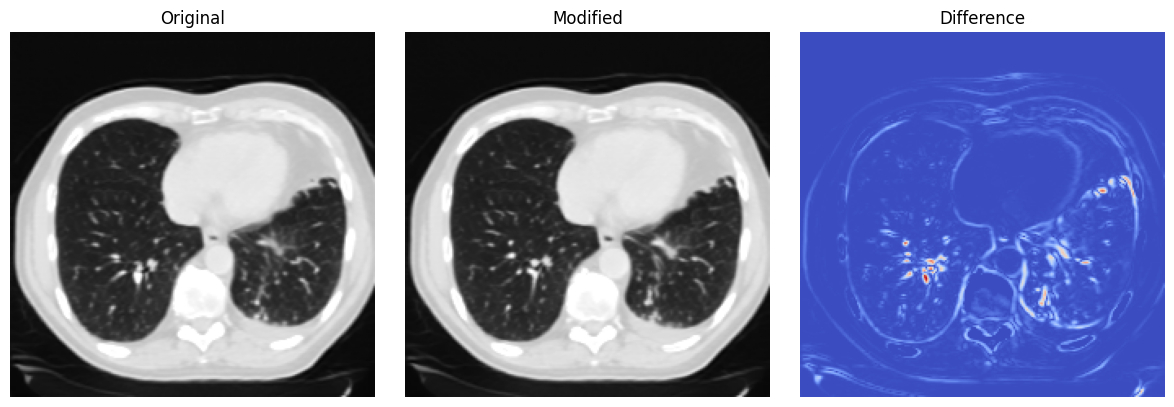

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming images are grayscale, shape = (1, H, W)
img1 = images[0][0]
img2 = images[-1][0]
diff = np.abs(img2 - img1)

# Create a figure
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Show original image
axs[0].imshow(img1, cmap='gray')
axs[0].set_title("Original")
axs[0].axis('off')

# Show modified image
axs[1].imshow(img2, cmap='gray')
axs[1].set_title("Modified")
axs[1].axis('off')

# Show difference
axs[2].imshow(diff, cmap='coolwarm')  # or use 'bwr'/'coolwarm' to highlight +/-
axs[2].set_title("Difference")
axs[2].axis('off')

plt.tight_layout()
plt.show()


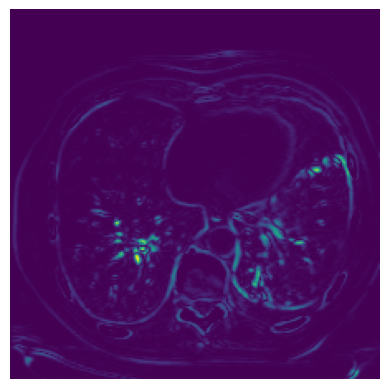

In [32]:
plt.imshow(np.abs(images[0][0] - images[-1][0]));
plt.axis('off');

In [33]:
latentshift.video_utils.generate_video({'generated_images':images, 'preds':np.array(output['preds'])-(np.array(output['preds']).min())}, "effusion", show_pred=True, watermark=False, cmap='gray',
                                       extra_loops=0,
                                      ffmpeg_path='/usr/bin/ffmpeg',
                                      resize=512)


/usr/bin/ffmpeg -loglevel quiet -stats -y -i /tmp/gifsplanation/image-%d.png -c:v libx264 -vf scale=-2:512 -profile:v baseline -level 3.0 -pix_fmt yuv420p 'effusion.mp4'
b''
